In [88]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [89]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [90]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect,func,text
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [91]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [92]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [93]:
# View all of the classes that automap found
# View all the classes that automap found
all_classes = Base.classes.keys()
print("All classes found by automap:")
for cls in all_classes:
    print(cls)


All classes found by automap:
measurement
station


In [94]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [95]:
# Create our session (link) from Python to the DB
session = Session(engine)

#inspect the tables to confirm the setup
inspector = inspect(engine)
table_names = inspector.get_table_names()
print(f"Tables in the database: {table_names}")
for table_name in table_names:
    columns = inspector.get_columns(table_name)
    print(f"\nColumns in {table_name}:")
    for column in columns:
        print(f"{column['name']} ({column['type']})")

Tables in the database: ['measurement', 'station']

Columns in measurement:
id (INTEGER)
station (TEXT)
date (TEXT)
prcp (FLOAT)
tobs (FLOAT)

Columns in station:
id (INTEGER)
station (TEXT)
name (TEXT)
latitude (FLOAT)
longitude (FLOAT)
elevation (FLOAT)


# Exploratory Precipitation Analysis

In [96]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


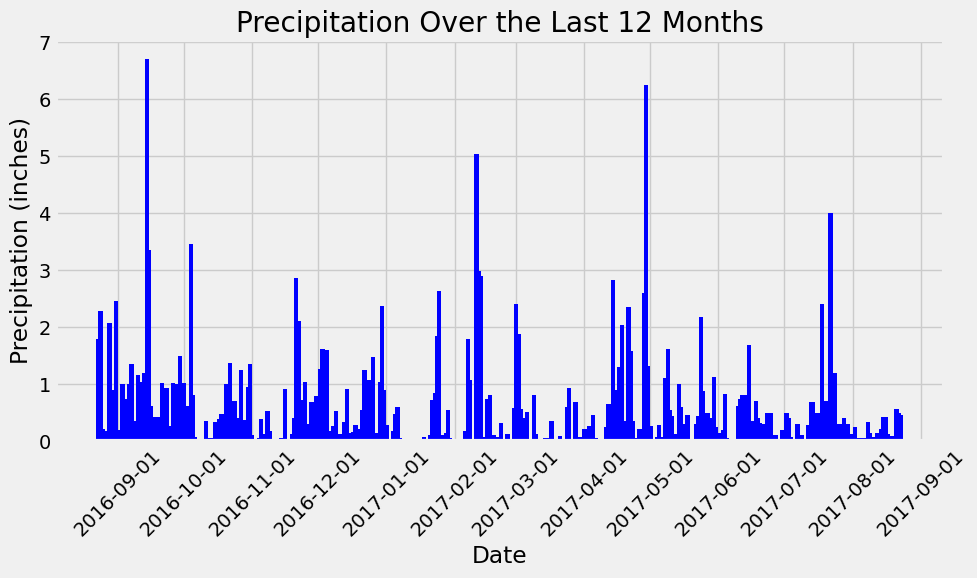

In [97]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago
one_year_ago = most_recent_date - timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= func.strftime('%Y-%m-%d', most_recent_date, '-365 days')).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# (make sure 'Date' is in datetime format)
df['Date'] = pd.to_datetime(df['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df['Date'], df['Precipitation'], width=2, color='blue')  # Adjusted bar width and color
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')

# Configure x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to be monthly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the date display
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Layout adjustments
plt.tight_layout()

# Show plot
plt.show()


In [98]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()

# Print the summary statistics
display(summary_statistics)


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [99]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [100]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)}
station_counts = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')
).group_by(
    Measurement.station
).order_by(
    func.count(Measurement.station).desc()
).all()

# List the stations and their counts in descending order.
for station, count in station_counts:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [101]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find the most active station (i.e., the station with the most rows)
most_active_station = session.query(
    Measurement.station, 
    func.count(Measurement.station).label('count')
).group_by(
    Measurement.station
).order_by(
    func.count(Measurement.station).desc()
).first()[0]  # Retrieves the station ID of the most active station

print(f"Most Active Station: {most_active_station}")

# Calculate the lowest, highest, and average temperatures for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(
    Measurement.station == most_active_station
).one()  # Fetches the stats as a single tuple

min_temp, max_temp, avg_temp = temperature_stats

# Output the temperature stats for the most active station
print(f"Lowest Temperature at Station {most_active_station}: {min_temp}°F")
print(f"Highest Temperature at Station {most_active_station}: {max_temp}°F")
print(f"Average Temperature at Station {most_active_station}: {avg_temp:.2f}°F")

Most Active Station: USC00519281
Lowest Temperature at Station USC00519281: 54.0°F
Highest Temperature at Station USC00519281: 85.0°F
Average Temperature at Station USC00519281: 71.66°F


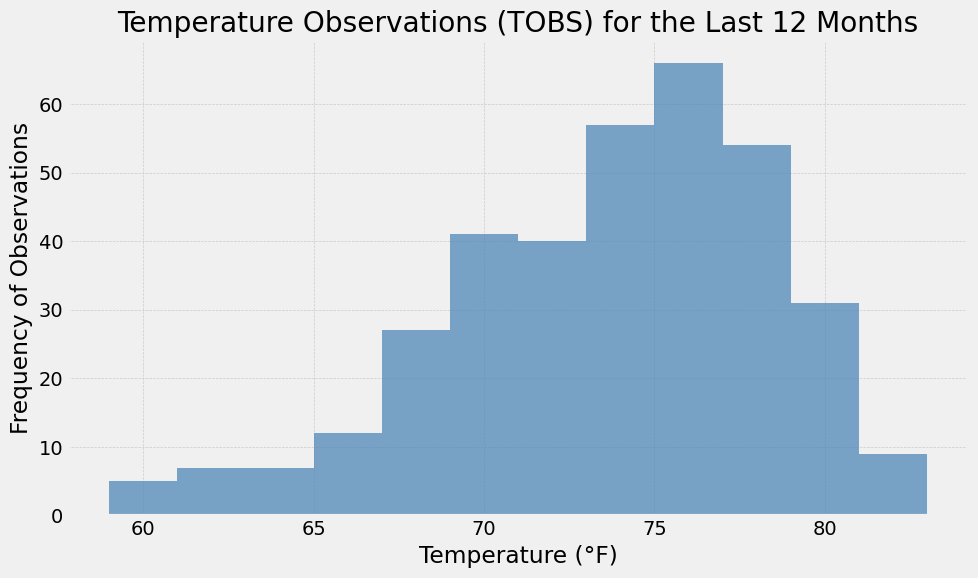

In [102]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station = 'USC00519281' 

# Find the most recent date of data for the most active station
most_recent_date = session.query(func.max(Measurement.date)).\
    filter(Measurement.station == most_active_station).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago from the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Retrieve the last 12 months of temperature observation data for this station
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()


df_tobs = pd.DataFrame(tobs_data, columns=['Date', 'Temperature'])

# Convert 'Temperature' to numeric, if not already (to handle any potential data type issues)
df_tobs['Temperature'] = pd.to_numeric(df_tobs['Temperature'], errors='coerce')

# Plotting the results as a histogram
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.hist(df_tobs['Temperature'], bins=12, color='steelblue', alpha=0.7)  # Histogram with 12 bins
plt.title('Temperature Observations (TOBS) for the Last 12 Months')  # Title of the histogram
plt.xlabel('Temperature (°F)')  # Label for the x-axis
plt.ylabel('Frequency of Observations')  # Label for the y-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid for better readability
plt.tight_layout()  # Adjust the layout to make room for the labels
plt.show()  # Display the plot


# Close Session

In [103]:
# Close Session
session.close()